In [55]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
%matplotlib inline
import re
import tensorflow as tf
from keras.callbacks import ModelCheckpoint   
import psycopg2 
from psycopg2 import sql
import pandas as pd
import pandas.io.sql as sqlio
from sqlalchemy import create_engine

In [66]:
# follows django database settings format, replace with your own settings
# create sqlalchemy engine
conn = psycopg2.connect(
    database="HousePricePrediction",
    user="postgres",
    password="postgres",
    host="dataviz.chu6ksowwwek.us-east-1.rds.amazonaws.com",
    port='5432'
)
cur=conn.cursor()
cur.execute(sql.SQL("SELECT * FROM {}").format(sql.Identifier('PropertyDetails')))

data=cur.fetchall()
data
column_name=["propertyLocation_id", "props.bedrooms", "props.bathrooms", "props.price", "props.variableData", "props.zestimate", "props.rentestimate", "props.livingArea", "props.lotAreaValue", "propertyType_id", "propertyUnit_id"]
propertyDetails_df= pd.DataFrame(data, columns=column_name)
# read a table from database into pandas dataframe, replace "tablename" with your table name
propertyDetails_df

,propertyLocation_id,props.bedrooms,props.bathrooms,props.price,props.variableData,props.zestimate,props.rentestimate,props.livingArea,props.lotAreaValue,propertyType_id,propertyUnit_id
0,1,3.0,3.0,471900,Sold 04/28/2023,471400.0,2289,2245.0,0.920000,1,1
1,2,3.0,3.0,375000,Sold 04/28/2023,373700.0,1999,1815.0,0.350000,1,1
2,3,3.0,3.0,382500,Sold 04/28/2023,446000.0,2294,2350.0,0.429982,1,1
3,4,3.0,2.0,330000,Sold 04/28/2023,329700.0,1800,1332.0,0.260000,1,1
4,5,4.0,3.0,680000,Sold 04/28/2023,677600.0,2988,2600.0,0.920000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
8842,8843,3.0,2.0,245000,Sold 01/12/2022,298800.0,1594,1310.0,0.480000,1,1
8843,8844,3.0,3.0,270000,Sold 01/12/2022,301600.0,1645,1263.0,8276.400000,1,2
8844,8845,3.0,3.0,470000,Sold 01/12/2022,492800.0,2094,1772.0,8276.400000,1,2
8845,8846,3.0,2.0,332000,Sold 01/11/2022,348300.0,2028,1408.0,0.326000,1,1


In [2]:
# Read data
data_w = pd.read_csv("zillow_wake_co.csv")
data_d = pd.read_csv("zillow_durham_co_df.csv")

In [3]:
# Concatenate both dataframes
data = pd.concat([data_w, data_d], axis=0)
data

,props.dateSold,props.propertyType,props.lotAreaValue,props.address,props.variableData.text,props.variableData.type,props.zestimate,props.imgSrc,props.price,props.bedrooms,...,props.daysOnZillow,props.bathrooms,props.livingArea,props.country,props.currency,props.lotAreaUnit,props.hasImage,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,1682665200000,SINGLE_FAMILY,0.920000,"7525 Matherly Dr, Wake Forest, NC 27587",Sold 04/28/2023,RECENTLY_SOLD,471400.0,https://photos.zillowstatic.com/fp/f5b8c1b3a5e...,471900,3.0,...,-1,3.0,2245.0,USA,USD,acres,True,NaN,NaN,NaN
1,1682665200000,SINGLE_FAMILY,0.350000,"132 W Holding Ave, Wake Forest, NC 27587",Sold 04/28/2023,RECENTLY_SOLD,373700.0,https://photos.zillowstatic.com/fp/cc3dddbd058...,375000,3.0,...,-1,3.0,1815.0,USA,USD,acres,True,NaN,NaN,NaN
2,1682665200000,SINGLE_FAMILY,0.429982,"2809 Stirrup Ct, Wake Forest, NC 27587",Sold 04/28/2023,RECENTLY_SOLD,446000.0,https://maps.googleapis.com/maps/api/staticmap...,382500,3.0,...,-1,3.0,2350.0,USA,USD,acres,True,NaN,NaN,NaN
3,1682665200000,SINGLE_FAMILY,0.260000,"900 Finchurch Cir, Wake Forest, NC 27587",Sold 04/28/2023,RECENTLY_SOLD,329700.0,https://photos.zillowstatic.com/fp/c16d597cdf7...,330000,3.0,...,-1,2.0,1332.0,USA,USD,acres,True,NaN,NaN,NaN
4,1682665200000,SINGLE_FAMILY,0.920000,"2812 Kimmon Way, Wake Forest, NC 27587",Sold 04/28/2023,RECENTLY_SOLD,677600.0,https://photos.zillowstatic.com/fp/bf2640f3101...,680000,4.0,...,-1,3.0,2600.0,USA,USD,acres,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,1641974400000,SINGLE_FAMILY,0.480000,"4 S Nipper Ct, Durham, NC 27704",Sold 01/12/2022,RECENTLY_SOLD,298800.0,https://photos.zillowstatic.com/fp/697f70fb343...,245000,3.0,...,-1,2.0,1310.0,USA,USD,acres,True,NaN,NaN,NaN
4304,1641974400000,SINGLE_FAMILY,8276.400000,"2004 Buffalo Way, Durham, NC 27704",Sold 01/12/2022,RECENTLY_SOLD,301600.0,https://photos.zillowstatic.com/fp/788db1bbbdd...,270000,3.0,...,-1,3.0,1263.0,USA,USD,sqft,True,NaN,NaN,NaN
4305,1641974400000,SINGLE_FAMILY,8276.400000,"3008 Kenan Rd, Durham, NC 27704",Sold 01/12/2022,RECENTLY_SOLD,492800.0,https://photos.zillowstatic.com/fp/98eedd159e7...,470000,3.0,...,-1,3.0,1772.0,USA,USD,sqft,True,NaN,NaN,NaN
4306,1641888000000,SINGLE_FAMILY,0.326000,"703 W Carver St, Durham, NC 27704",Sold 01/11/2022,RECENTLY_SOLD,348300.0,https://photos.zillowstatic.com/fp/1ead45e8823...,332000,3.0,...,-1,2.0,1408.0,USA,USD,acres,True,NaN,NaN,NaN


In [4]:
# If props.AreaUnit is = to sqft then convert it to acres
data.loc[(data['props.lotAreaUnit'] == 'sqft'), 'props.lotAreaValue'] /= 43560
data

,props.dateSold,props.propertyType,props.lotAreaValue,props.address,props.variableData.text,props.variableData.type,props.zestimate,props.imgSrc,props.price,props.bedrooms,...,props.daysOnZillow,props.bathrooms,props.livingArea,props.country,props.currency,props.lotAreaUnit,props.hasImage,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,1682665200000,SINGLE_FAMILY,0.920000,"7525 Matherly Dr, Wake Forest, NC 27587",Sold 04/28/2023,RECENTLY_SOLD,471400.0,https://photos.zillowstatic.com/fp/f5b8c1b3a5e...,471900,3.0,...,-1,3.0,2245.0,USA,USD,acres,True,NaN,NaN,NaN
1,1682665200000,SINGLE_FAMILY,0.350000,"132 W Holding Ave, Wake Forest, NC 27587",Sold 04/28/2023,RECENTLY_SOLD,373700.0,https://photos.zillowstatic.com/fp/cc3dddbd058...,375000,3.0,...,-1,3.0,1815.0,USA,USD,acres,True,NaN,NaN,NaN
2,1682665200000,SINGLE_FAMILY,0.429982,"2809 Stirrup Ct, Wake Forest, NC 27587",Sold 04/28/2023,RECENTLY_SOLD,446000.0,https://maps.googleapis.com/maps/api/staticmap...,382500,3.0,...,-1,3.0,2350.0,USA,USD,acres,True,NaN,NaN,NaN
3,1682665200000,SINGLE_FAMILY,0.260000,"900 Finchurch Cir, Wake Forest, NC 27587",Sold 04/28/2023,RECENTLY_SOLD,329700.0,https://photos.zillowstatic.com/fp/c16d597cdf7...,330000,3.0,...,-1,2.0,1332.0,USA,USD,acres,True,NaN,NaN,NaN
4,1682665200000,SINGLE_FAMILY,0.920000,"2812 Kimmon Way, Wake Forest, NC 27587",Sold 04/28/2023,RECENTLY_SOLD,677600.0,https://photos.zillowstatic.com/fp/bf2640f3101...,680000,4.0,...,-1,3.0,2600.0,USA,USD,acres,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,1641974400000,SINGLE_FAMILY,0.480000,"4 S Nipper Ct, Durham, NC 27704",Sold 01/12/2022,RECENTLY_SOLD,298800.0,https://photos.zillowstatic.com/fp/697f70fb343...,245000,3.0,...,-1,2.0,1310.0,USA,USD,acres,True,NaN,NaN,NaN
4304,1641974400000,SINGLE_FAMILY,0.190000,"2004 Buffalo Way, Durham, NC 27704",Sold 01/12/2022,RECENTLY_SOLD,301600.0,https://photos.zillowstatic.com/fp/788db1bbbdd...,270000,3.0,...,-1,3.0,1263.0,USA,USD,sqft,True,NaN,NaN,NaN
4305,1641974400000,SINGLE_FAMILY,0.190000,"3008 Kenan Rd, Durham, NC 27704",Sold 01/12/2022,RECENTLY_SOLD,492800.0,https://photos.zillowstatic.com/fp/98eedd159e7...,470000,3.0,...,-1,3.0,1772.0,USA,USD,sqft,True,NaN,NaN,NaN
4306,1641888000000,SINGLE_FAMILY,0.326000,"703 W Carver St, Durham, NC 27704",Sold 01/11/2022,RECENTLY_SOLD,348300.0,https://photos.zillowstatic.com/fp/1ead45e8823...,332000,3.0,...,-1,2.0,1408.0,USA,USD,acres,True,NaN,NaN,NaN


In [5]:
# Extract zip code from address
data['zip'] = data['props.address'].str.extract('(?<=NC )([^,]*)(?=$)', expand = True)
data['zip'].astype(str).astype(int)
data['zip'].head()

0    27587
1    27587
2    27587
3    27587
4    27587
Name: zip, dtype: object

In [6]:
# Extract city code from address
data['city'] = data['props.address'].str.extract('(?<=, )([^,]*)(?=,)', expand = True)   
data['city'].head()

0    Wake Forest
1    Wake Forest
2    Wake Forest
3    Wake Forest
4    Wake Forest
Name: city, dtype: object

In [7]:
# Create data_df dataframe from select columns in data dataframe
data_df = data[['city','zip','props.zestimate','props.propertyType','props.bedrooms','props.bathrooms','props.livingArea','props.lotAreaValue','props.latitude','props.longitude']]

# Drop rows where bedrooms, bathrooms, or livingArea = 0
data_df = data_df[data_df['props.bedrooms'] != 0]
data_df = data_df[data_df['props.bathrooms'] != 0]
data_df = data_df[data_df['props.livingArea'] != 0]

# Drop NA
data_df = data_df.dropna()

data_df.head()

,city,zip,props.zestimate,props.propertyType,props.bedrooms,props.bathrooms,props.livingArea,props.lotAreaValue,props.latitude,props.longitude
0,Wake Forest,27587,471400.0,SINGLE_FAMILY,3.0,3.0,2245.0,0.920000,35.997555,-78.544770
1,Wake Forest,27587,373700.0,SINGLE_FAMILY,3.0,3.0,1815.0,0.350000,35.972195,-78.516880
2,Wake Forest,27587,446000.0,SINGLE_FAMILY,3.0,3.0,2350.0,0.429982,35.937810,-78.527550
3,Wake Forest,27587,329700.0,SINGLE_FAMILY,3.0,2.0,1332.0,0.260000,35.994972,-78.504776
4,Wake Forest,27587,677600.0,SINGLE_FAMILY,4.0,3.0,2600.0,0.920000,36.019070,-78.553570


In [8]:
# Change dtypes of columns
data_df['zip'] = data_df['zip'].astype(str).astype(int)
data_df['props.bedrooms'] = data_df['props.bedrooms'].astype(int)
data_df['props.bathrooms'] = data_df['props.bathrooms'].astype(int)
data_df.dtypes

city                   object
zip                     int32
props.zestimate       float64
props.propertyType     object
props.bedrooms          int32
props.bathrooms         int32
props.livingArea      float64
props.lotAreaValue    float64
props.latitude        float64
props.longitude       float64
dtype: object

In [9]:
# Describe data_df
data_df.describe()

,zip,props.zestimate,props.bedrooms,props.bathrooms,props.livingArea,props.lotAreaValue,props.latitude,props.longitude
count,8782.000000,8.782000e+03,8782.000000,8782.000000,8782.000000,8782.000000,8782.000000,8782.000000
mean,27634.991004,5.110381e+05,3.437144,2.729333,2187.121726,0.497488,35.888049,-78.794412
std,76.116451,2.805756e+05,0.847486,1.019434,1320.521611,1.826194,0.138120,0.147880
min,27502.000000,3.220000e+04,1.000000,1.000000,1.000000,0.000000,35.450110,-79.043860
25%,27571.000000,3.460000e+05,3.000000,2.000000,1454.250000,0.167000,35.776990,-78.911600
50%,27616.000000,4.453000e+05,3.000000,3.000000,1973.500000,0.250000,35.922020,-78.847495
75%,27705.000000,5.927000e+05,4.000000,3.000000,2683.000000,0.460000,35.996836,-78.690742
max,27713.000000,5.627300e+06,8.000000,10.000000,73140.000000,82.239991,36.145874,-78.401010


In [10]:
# Determine # of unique values per column
data_df.nunique()

city                    15
zip                     30
props.zestimate       4901
props.propertyType       7
props.bedrooms           8
props.bathrooms         10
props.livingArea      3000
props.lotAreaValue    1327
props.latitude        7766
props.longitude       7342
dtype: int64

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

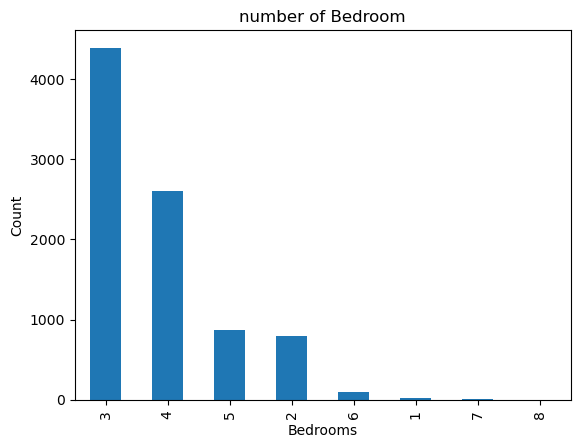

In [11]:
data_df['props.bedrooms'].value_counts().plot(kind='bar')
plt.title('number of Bedroom')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
sns.despine

Text(0.5, 1.0, 'Price vs Square Feet')

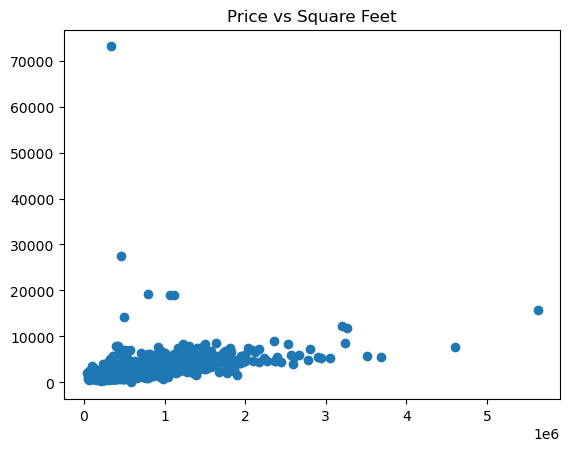

In [12]:
plt.scatter(data_df["props.zestimate"],data_df["props.livingArea"])
plt.title("Price vs Square Feet")

In [13]:
# Create dataframe that contains all variables except the zestimates
train_data = data_df.drop(['props.zestimate','props.longitude','props.latitude'], axis=1)
train_data

,city,zip,props.propertyType,props.bedrooms,props.bathrooms,props.livingArea,props.lotAreaValue
0,Wake Forest,27587,SINGLE_FAMILY,3,3,2245.0,0.920000
1,Wake Forest,27587,SINGLE_FAMILY,3,3,1815.0,0.350000
2,Wake Forest,27587,SINGLE_FAMILY,3,3,2350.0,0.429982
3,Wake Forest,27587,SINGLE_FAMILY,3,2,1332.0,0.260000
4,Wake Forest,27587,SINGLE_FAMILY,4,3,2600.0,0.920000
...,...,...,...,...,...,...,...
4303,Durham,27704,SINGLE_FAMILY,3,2,1310.0,0.480000
4304,Durham,27704,SINGLE_FAMILY,3,3,1263.0,0.190000
4305,Durham,27704,SINGLE_FAMILY,3,3,1772.0,0.190000
4306,Durham,27704,SINGLE_FAMILY,3,2,1408.0,0.326000


In [14]:
# categorical columns
categorical_cols = ['city','props.propertyType']

train_data= pd.get_dummies(train_data, columns = categorical_cols)
train_data

,zip,props.bedrooms,props.bathrooms,props.livingArea,props.lotAreaValue,city_Apex,city_Cary,city_Chapel Hill,city_Creedmoor,city_Durh,...,city_Raleigh,city_Rolesville,city_Wake Forest,props.propertyType_APARTMENT,props.propertyType_CONDO,props.propertyType_LOT,props.propertyType_MANUFACTURED,props.propertyType_MULTI_FAMILY,props.propertyType_SINGLE_FAMILY,props.propertyType_TOWNHOUSE
0,27587,3,3,2245.0,0.920000,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,27587,3,3,1815.0,0.350000,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,27587,3,3,2350.0,0.429982,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,27587,3,2,1332.0,0.260000,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,27587,4,3,2600.0,0.920000,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,27704,3,2,1310.0,0.480000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4304,27704,3,3,1263.0,0.190000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4305,27704,3,3,1772.0,0.190000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4306,27704,3,2,1408.0,0.326000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [15]:
# set up linear regression on data
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

In [16]:
# Train-Test-Split data
from sklearn.model_selection import train_test_split

labels = data_df['props.zestimate']
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, test_size = 0.20, random_state = 42)

In [17]:
reg.fit(x_train,y_train)

LinearRegression()

In [18]:
reg.score(x_test,y_test)

0.4936586297258472

In [19]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'squared_error')

In [20]:
clf.fit(x_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=400)

In [21]:
clf.score(x_test,y_test)

0.7262200628683402

In [22]:
## Train the model with PMML wrapper
from sklearn2pmml.pipeline import PMMLPipeline

clf = PMMLPipeline(
    [
        (
            "classifier",
            ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'squared_error'),
        )
    ]
)

In [23]:
clf.fit(x_train, y_train)

PMMLPipeline(steps=[('classifier', GradientBoostingRegressor(max_depth=5, n_estimators=400))])

In [24]:
clf.score(x_test,y_test)

0.7288542218859078

In [25]:
## Save model to PMML
from sklearn2pmml import sklearn2pmml

sklearn2pmml(clf, "boosting_model.pmml", with_repr=True)

RuntimeError: Java is not installed, or the Java executable is not on system path

In [26]:
try:
	subprocess.check_call(["java", "-cp", _classpath(), "org.jpmml.sklearn.Main"])
except CalledProcessError:
	raise RuntimeError("The JPMML-SkLearn conversion application has failed.")

NameError: name 'CalledProcessError' is not defined